In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyet as pyet

In [48]:
#read data
data_16412 = pd.read_csv('penman/klima_daily.csv', index_col=1, parse_dates=True)
data_16412

,station,strahl,rel,t,tmax,tmin,vv
time,,,,,,,
2000-01-01,16412,300.0,80.0,-2.7,0.5,-5.8,1.0
2000-01-02,16412,250.0,86.0,0.2,2.5,-2.1,1.0
2000-01-03,16412,598.0,86.0,0.6,3.6,-2.4,1.0
2000-01-04,16412,619.0,83.0,-0.5,4.5,-5.5,1.0
2000-01-05,16412,463.0,84.0,-0.1,5.4,-5.5,1.0
...,...,...,...,...,...,...,...
2021-11-07,16412,852.0,74.0,8.5,12.2,4.7,1.6
2021-11-08,16412,553.0,78.0,7.5,10.4,4.5,1.6
2021-11-09,16412,902.0,67.0,7.1,11.7,2.4,2.7


In [49]:
# Convert Glabalstrahlung J/cm2 to MJ/m2 by dividing to 100

meteo = pd.DataFrame({"time":data_16412.index, "tmean":data_16412.t, "tmax":data_16412.tmax, "tmin":data_16412.tmin, "rh":data_16412.rel, 
                      "wind":data_16412.vv, "rs":data_16412.strahl/100})
time, tmean, tmax, tmin, rh, wind, rs = [meteo[col] for col in meteo.columns]

lat = 47.077778*np.pi/180  # Latitude of the meteorological station, converting from degrees to radians
elevation = 367  # meters above sea-level

lambda1=pyet.calc_lambda(tmean=tmean)  # Latent Heat of Vaporization in PyEt [MJ kg-1] 
lambda0 = 2.45  # Latent Heat of Vaporization in Guo et al., 2016 [MJ kg-1] 
lambda_corr = lambda1 / lambda0  # Correction factor

In [50]:
pyet_penman = pyet.penman(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh, aw=1, bw=0.526, albedo=0.08) #* lambda_corr

pyet_oudin = pyet.oudin(tmean, lat)

pyet_haude = pyet.haude(tmean, rh)

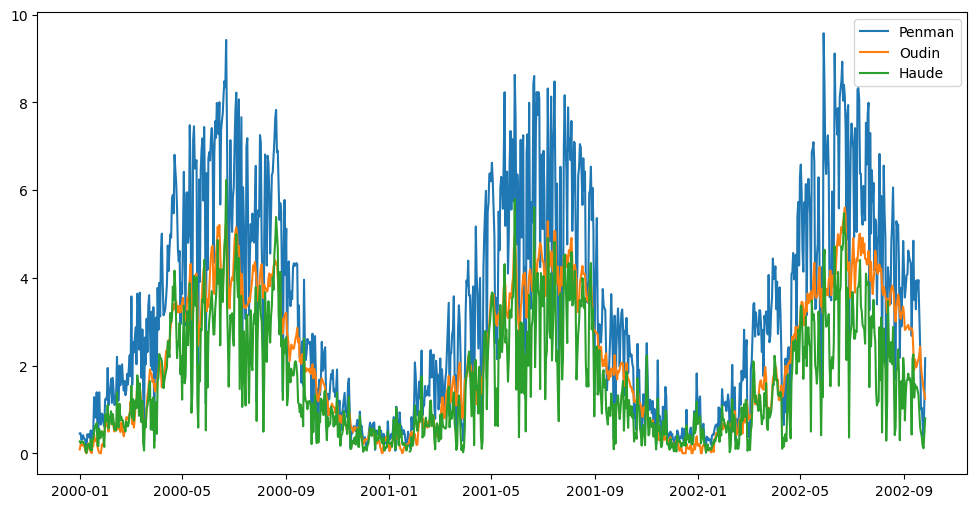

In [51]:
# plot all 3
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# plot the data
ax.plot(pyet_penman[:1000])
ax.plot(pyet_oudin[:1000])
ax.plot(pyet_haude[:1000])

# include a legend
ax.legend(['Penman', 'Oudin', 'Haude'])

In [52]:
# remove np.nans from the data to avoid errors when plotting the data
pyet_penman = pyet_penman.dropna()
pyet_haude = pyet_haude.dropna()
pyet_oudin = pyet_oudin.dropna()

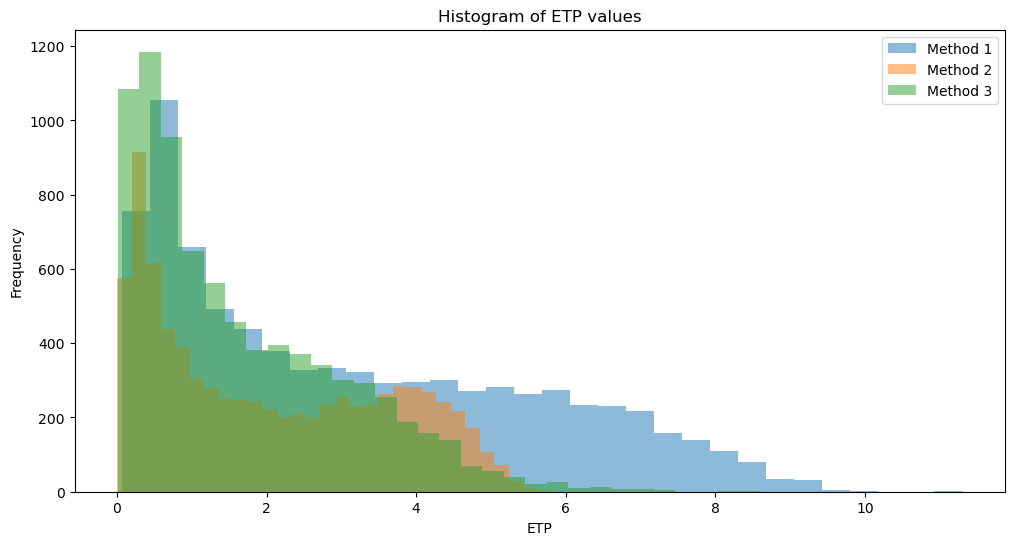

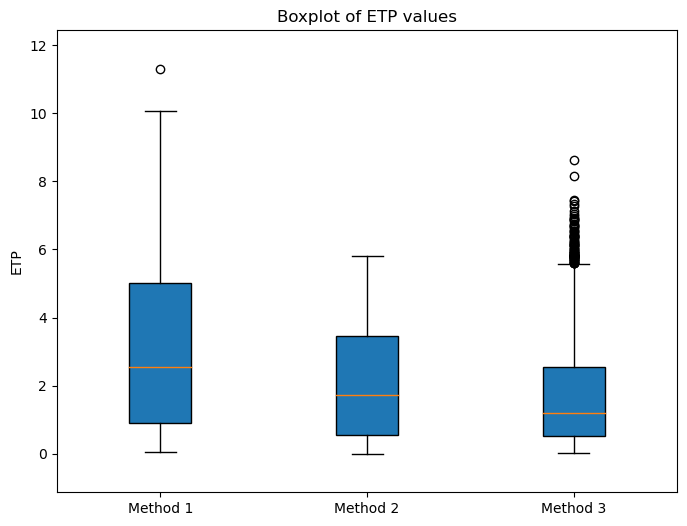

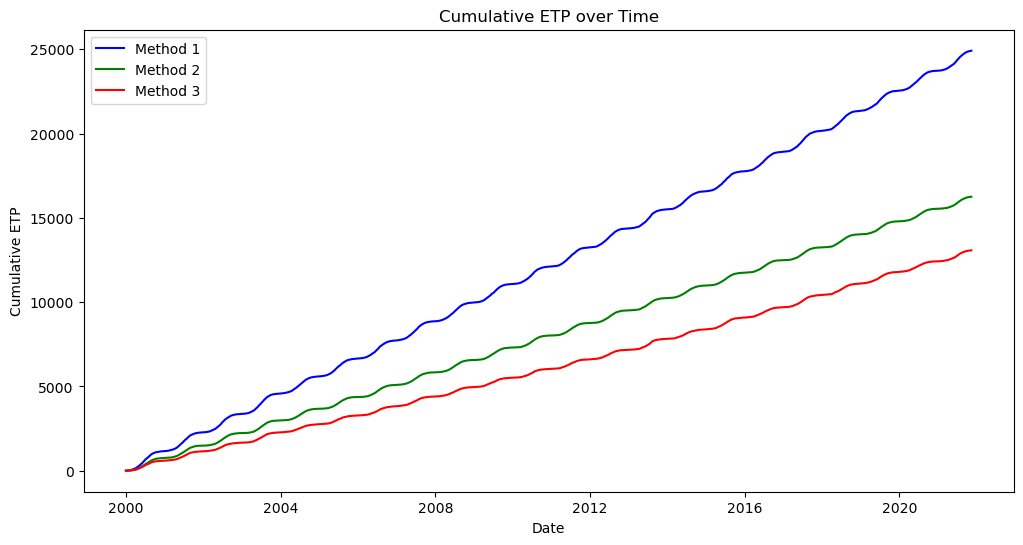

In [53]:
# 1. Histogram
plt.figure(figsize=(12, 6))
plt.hist(pyet_penman, bins=30, alpha=0.5, label='Method 1')
plt.hist(pyet_oudin, bins=30, alpha=0.5, label='Method 2')
plt.hist(pyet_haude, bins=30, alpha=0.5, label='Method 3')
plt.title('Histogram of ETP values')
plt.xlabel('ETP')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# 2. Boxplot
data = [pyet_penman.values, pyet_oudin.values, pyet_haude.values]
plt.figure(figsize=(8, 6))
plt.boxplot(data, vert=True, patch_artist=True, labels=['Method 1', 'Method 2', 'Method 3'])
plt.title('Boxplot of ETP values')
plt.ylabel('ETP')

# Set y-axis limits for better visualization
min_val = min(pyet_penman.min(), pyet_oudin.min(), pyet_haude.min())
max_val = max(pyet_penman.max(), pyet_oudin.max(), pyet_haude.max())
plt.ylim(min_val - 0.1*(max_val - min_val), max_val + 0.1*(max_val - min_val))

plt.show()

# 3. Cumulative ETP
cumulative_etp1 = pyet_penman.cumsum()
cumulative_etp2 = pyet_oudin.cumsum()
cumulative_etp3 = pyet_haude.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_etp1.index, cumulative_etp1.values, label='Method 1', color='blue')
plt.plot(cumulative_etp2.index, cumulative_etp2.values, label='Method 2', color='green')
plt.plot(cumulative_etp3.index, cumulative_etp3.values, label='Method 3', color='red')
plt.title('Cumulative ETP over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative ETP')
plt.legend(loc='upper left')
plt.show()


<Figure size 1400x700 with 0 Axes>

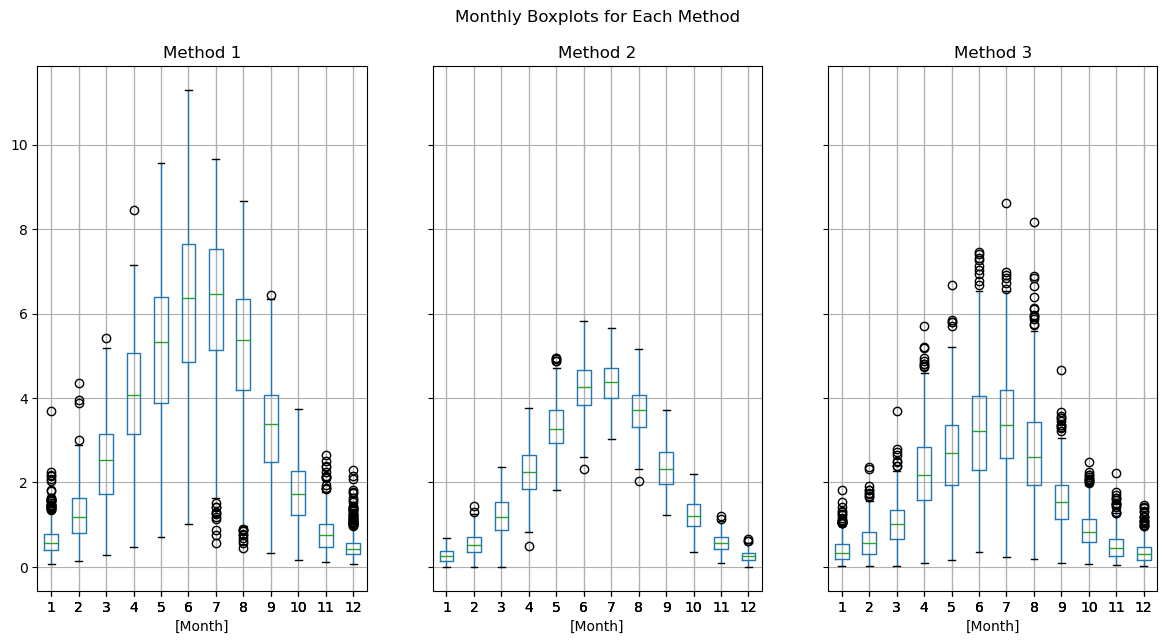

In [61]:
# Extract month from the index
df = pd.DataFrame({
    'Method 1': pyet_penman,
    'Method 2': pyet_oudin,
    'Method 3': pyet_haude
})
df['Month'] = df.index.month

plt.figure(figsize=(14, 7))
df.boxplot(by='Month', layout=(1, 3), figsize=(14, 7))
plt.suptitle('Monthly Boxplots for Each Method')
plt.show()

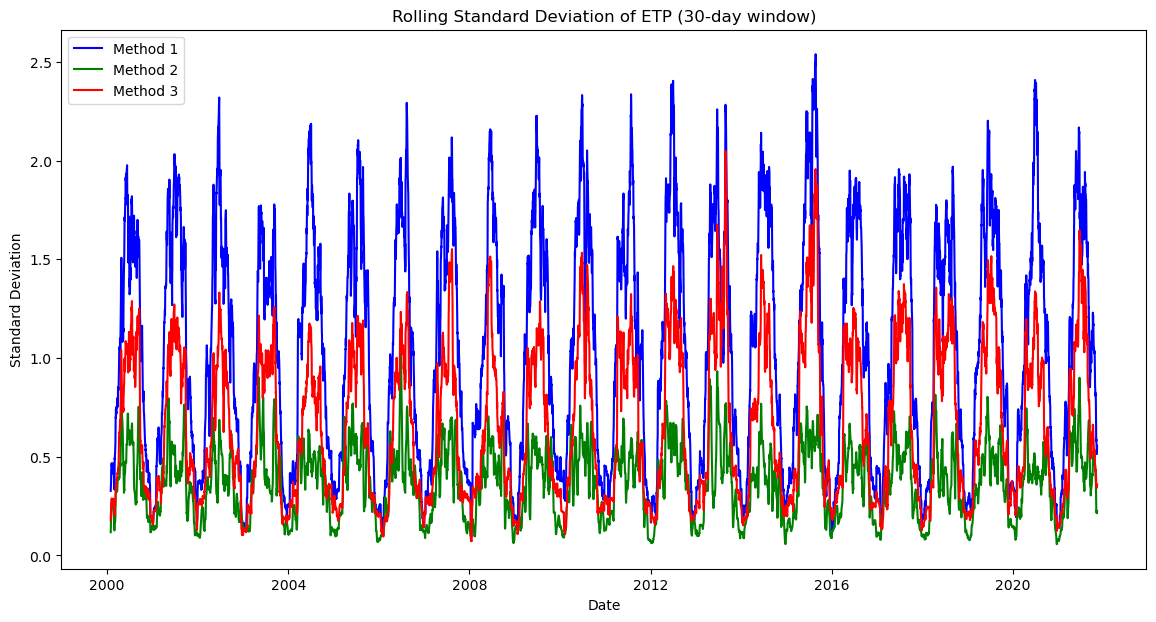

In [64]:
# Calculate rolling standard deviation with a window size (e.g., 30 days)
rolling_std_1 = pyet_penman.rolling(window=30).std()
rolling_std_2 = pyet_oudin.rolling(window=30).std()
rolling_std_3 = pyet_haude.rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(rolling_std_1, label='Method 1', color='blue')
plt.plot(rolling_std_2, label='Method 2', color='green')
plt.plot(rolling_std_3, label='Method 3', color='red')
plt.title('Rolling Standard Deviation of ETP (30-day window)')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()